In [1]:
import os
from pathlib import Path
import options_wizard as ow
from dotenv import load_dotenv
load_dotenv()
tick_path = os.getenv("TICK_PATH", "").split(os.pathsep)[0]

p = Path(tick_path)
if p.is_dir(): 
    available_ticks =[f.name.replace('.parquet', '') for f in p.iterdir() if f.is_file()]

start_date = ow.DateObj(2010, 1, 1)
end_date = ow.DateObj(2020, 12, 31)
save_type = ow.SaveType.PICKLE
stock = 'NDQ'
universe = ow.Universe([stock])


In [ ]:
from functools import partial
from operator import le, eq

    

pipeline = ow.Pipeline(universe=universe, save_type=save_type, saves = [ow.SaveFrames.STRAT])
kwargs = {
    'max_date': end_date.to_pl(),
    'keep_col' : ['call_put', 'ttm', 'n_missing'],
    'keep_oper': [eq, le, le],
    'keep_val': ['p', 150, 0],
    'delta_otm': 0.10,
    'delta_mtm': 0.30,
    'delta_atm': 0.4,
    'atm_ratio': 1,
    'mtm_ratio': -2,
    'otm_ratio': 2,
    'lower_ttm': 31,
    'upper_ttm': 150,
    'hold_period': 30,
    'protected_notional': 1_000_000,
    }

ow.wrap_fn = partial(ow.wrap_fn, pipeline=pipeline, kwargs=kwargs)
ow.add_idx_ladder_methods(pipeline, kwargs)


In [3]:
pipeline.run()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:52<00:00, 52.93s/it]


In [4]:
import options_wizard as ow
from functools import partial

start_cash = 1_000_000


ptf = partial(
    ow.Trade,
    transaction_cost_model=ow.TransactionCostModel.SPREAD,
    accounting_type=ow.AccountingConvention.CASH
)
cfg = ow.BackTestConfig(
    starting_cash = start_cash,
    start_date=start_date,
    end_date=end_date,
    kwargs=kwargs
)
position = ow.FixedHoldNotional(cfg)

strat = ow.StratType.load(stock, save_type=save_type)  
trades = strat.reconstruct(ptf)
position.add_trade(trades)

In [5]:
result = ow.BackTestCoordinator(
    position = position,
    dates = ow.market_dates(start_date, end_date, exchange=ow.Exchange.NASDAQ),
    debug = True
).run()

100%|██████████| 2769/2769 [00:08<00:00, 316.42it/s]


Text(0, 0.5, 'Number of Open Trades')

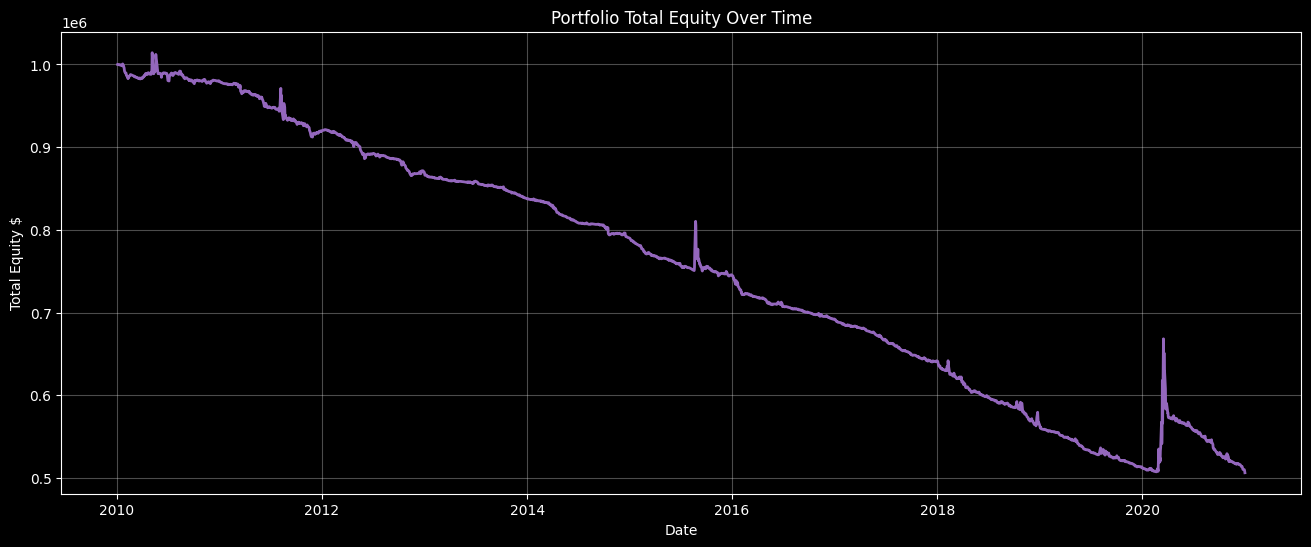

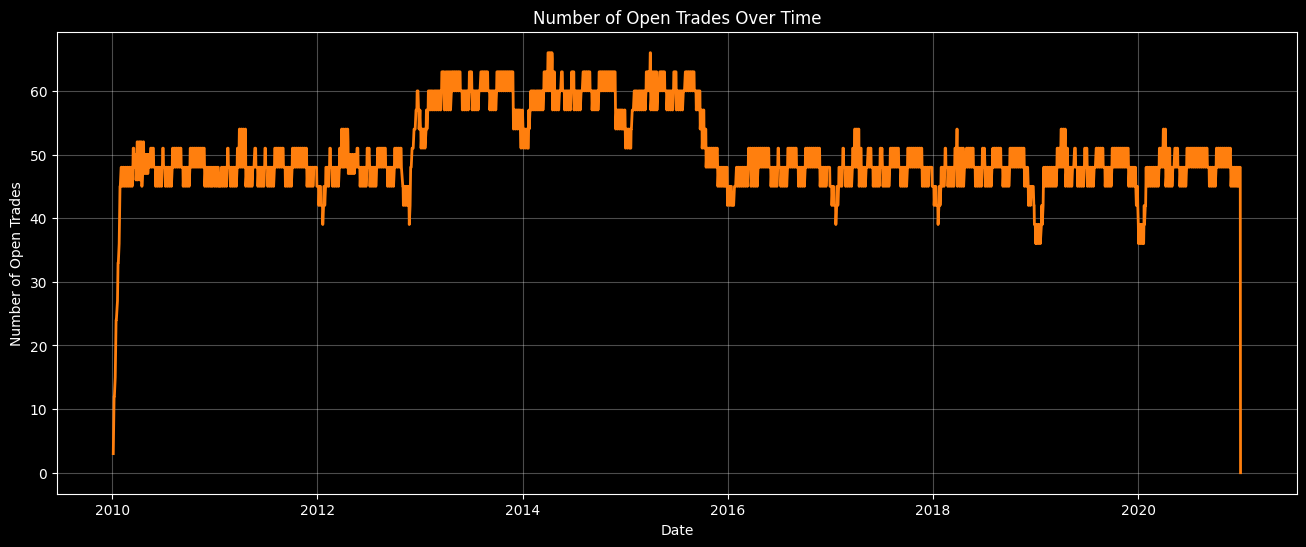

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotx 
import numpy as np
from statistics import mean

mpl.style.use("dark_background")

equity = np.array([snap.total_equity + snap.total_cash for snap in result.snapshots])
n_trades = np.array([len([key for key in snap.trade_equities.keys()]) for snap in result.snapshots])

dates = np.array([snap.date.to_datetime() for snap in result.snapshots])

fig2, ax2 = plt.subplots(figsize=(16, 6))
ax2.plot(dates, equity, color="tab:purple", lw=2, label="Total Equity")
ax2.grid(True, alpha=0.3)
ax2.set_title("Portfolio Total Equity Over Time")
ax2.set_xlabel("Date")
ax2.set_ylabel("Total Equity $")

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(dates, n_trades, color="tab:orange", lw=2, label="Number of Open Trades")
ax.grid(True, alpha=0.3)
ax.set_title("Number of Open Trades Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Open Trades")  